<a href="https://colab.research.google.com/github/Yuxi-Cn/Personal_Loan_Modelling/blob/main/Personal_Loan_Modelling_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **1. Library Import**

In [28]:
pip install zipcodes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.6/719.6 kB 4.8 MB/s eta 0:00:00


In [29]:
pip install -q ydata-profiling

In [30]:
%matplotlib inline
# import libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import plotly.express as px
import zipcodes as zcode
from plotly.subplots import make_subplots
from ydata_profiling import ProfileReport
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from datetime import datetime

## **2. Data Exploration**

### 2.1 Data loading

In [31]:
# use pandas library to read the csv file
df = pd.read_csv("Bank_Personal_Loan_Modelling.csv")

In [32]:
df.head()

ID  Age  Experience  Income  ZIP Code  Family  CCAvg  Education  Mortgage  \
0   1   25           1      49     91107       4    1.6          1         0   
1   2   45          19      34     90089       3    1.5          1         0   
2   3   39          15      11     94720       1    1.0          1         0   
3   4   35           9     100     94112       1    2.7          2         0   
4   5   35           8      45     91330       4    1.0          2         0   

   Personal Loan  Securities Account  CD Account  Online  CreditCard  
0              0                   1           0       0           0  
1              0                   1           0       0           0  
2              0                   0           0       0           0  
3              0                   0           0       0           0  
4              0                   0           0       0           1

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  5000 non-null   int64  
 1   Age                 5000 non-null   int64  
 2   Experience          5000 non-null   int64  
 3   Income              5000 non-null   int64  
 4   ZIP Code            5000 non-null   int64  
 5   Family              5000 non-null   int64  
 6   CCAvg               5000 non-null   float64
 7   Education           5000 non-null   int64  
 8   Mortgage            5000 non-null   int64  
 9   Personal Loan       5000 non-null   int64  
 10  Securities Account  5000 non-null   int64  
 11  CD Account          5000 non-null   int64  
 12  Online              5000 non-null   int64  
 13  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


In [34]:
# calculate descriptive statistics for the dataset
descriptive_stats = df.describe().T

# create a heatmap style representation of the descriptive statistics
colormap = sns.color_palette("GnBu", as_cmap=True)
heatmap_style = descriptive_stats.style.background_gradient(cmap=colormap)

heatmap_style

Remove the 'ID' columns from the DataFrame 'df' as the column is likely an irrelevant feature for the loan prediction model, and removing them simplifies the model input.

In [35]:
# drop ID columns from df as they are irrelevant features in this case
df = df.drop(['ID'], axis=1)

In [36]:
# change monthly spending to annual spending to improve data consistency
df['CCAvg'] = df['CCAvg'] * 12

In [37]:
df.head()

Age  Experience  Income  ZIP Code  Family  CCAvg  Education  Mortgage  \
0   25           1      49     91107       4   19.2          1         0   
1   45          19      34     90089       3   18.0          1         0   
2   39          15      11     94720       1   12.0          1         0   
3   35           9     100     94112       1   32.4          2         0   
4   35           8      45     91330       4   12.0          2         0   

   Personal Loan  Securities Account  CD Account  Online  CreditCard  
0              0                   1           0       0           0  
1              0                   1           0       0           0  
2              0                   0           0       0           0  
3              0                   0           0       0           0  
4              0                   0           0       0           1

### 2.2 Pre-stage data visualisation

In [38]:
# descriptive report for dataset features
ProfileReport(df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

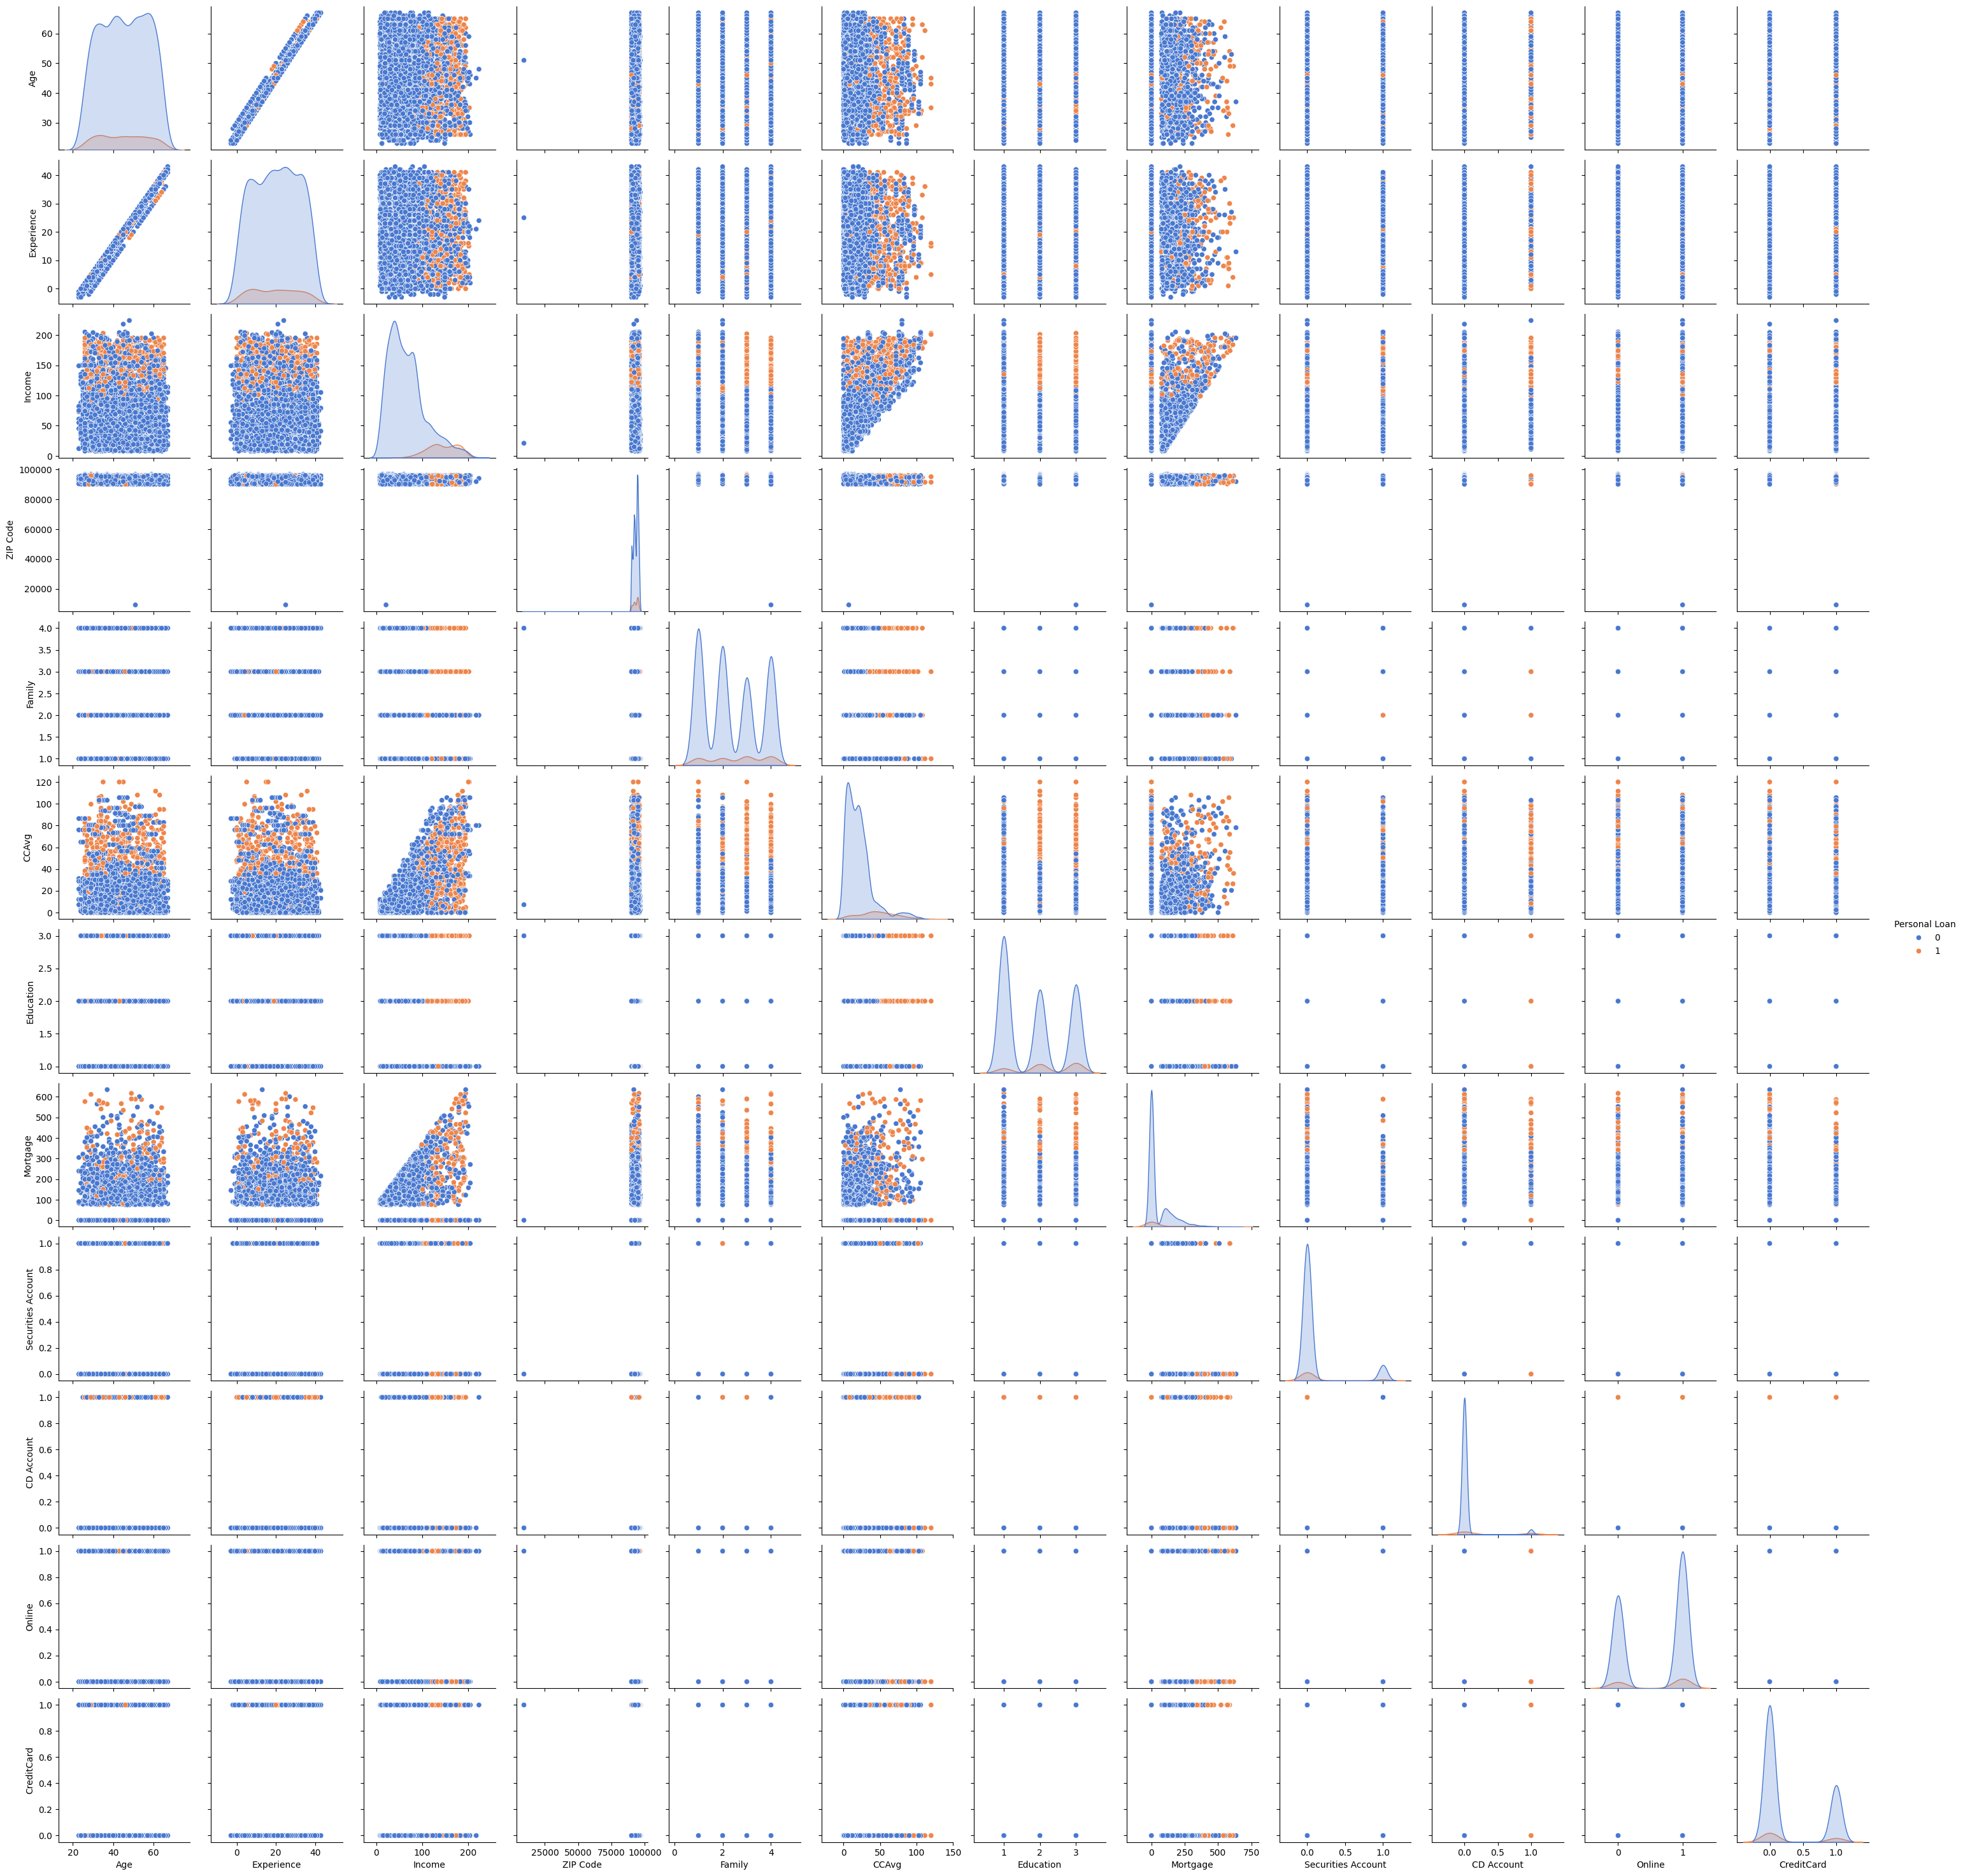

In [39]:
sns.pairplot(df, hue="Personal Loan", palette="muted")
plt.show()

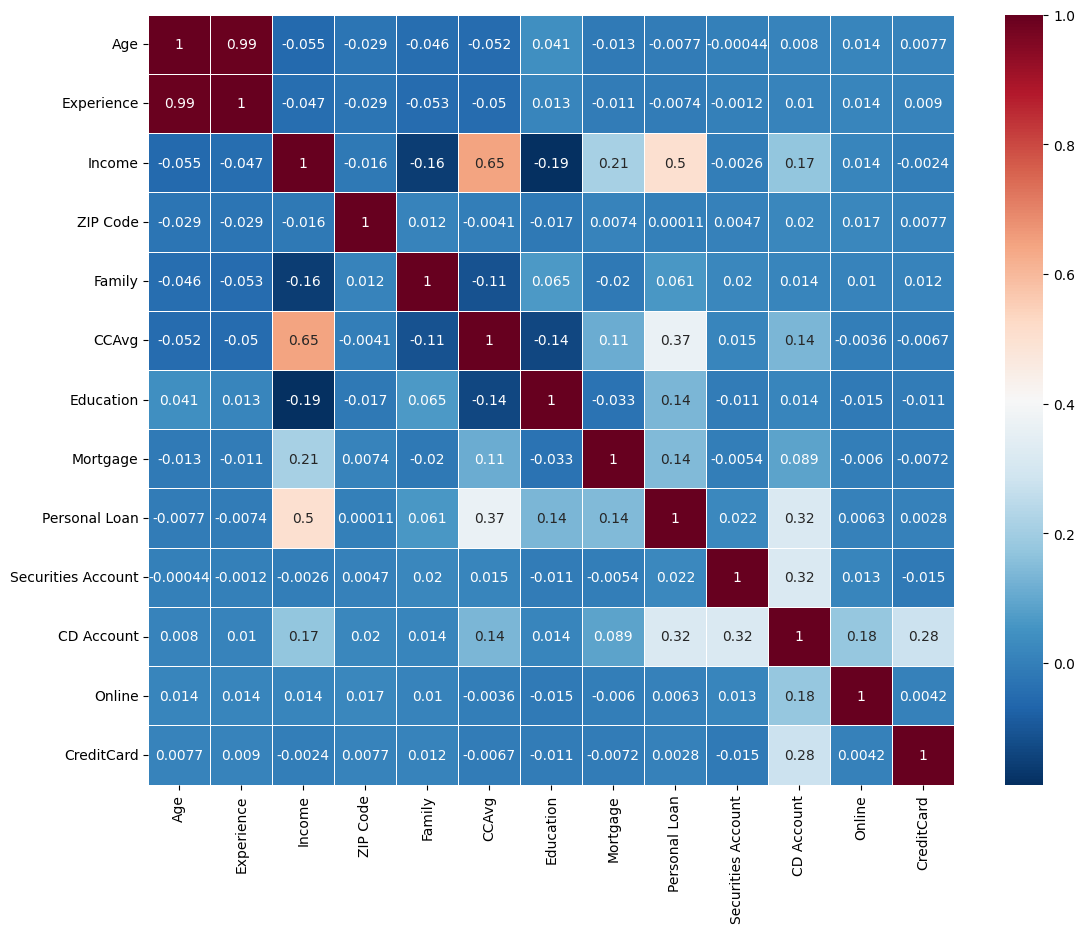

In [40]:
# heatmap
plt.figure(figsize=(13, 10))
sns.heatmap(df.corr(), cmap='RdBu_r', annot=True, linewidths=0.5, cbar=True)
plt.show()

The pairplot aims to visualise pairwise relationships in the dataset, with distinct colors representing the 'Personal Loan' status (blue for 0, yellow for 1). Similarily, the heatmap illustrates the correlations of all features.

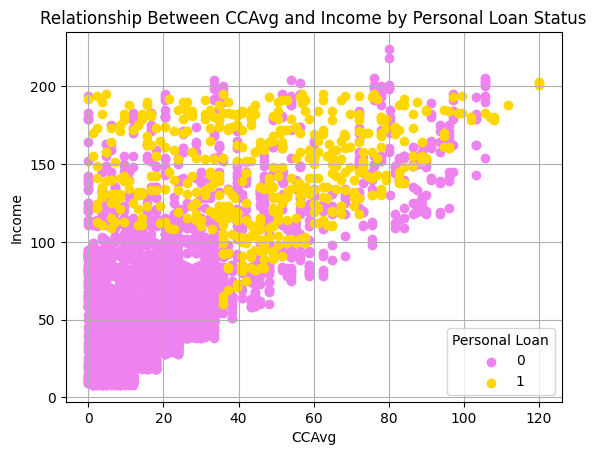

In [41]:
# the scatter plot showing the relationship between avgerage credit card spending and income (both units are annual)
feature1 = 'CCAvg'
feature2 = 'Income'
species = df['Personal Loan'].unique()
colors = {0: 'Violet', 1: 'Gold'}
for label in species:
    plt.scatter(df.loc[df['Personal Loan'] == label, feature1],
                df.loc[df['Personal Loan'] == label, feature2],
                c=colors[label], label=label)

plt.xlabel(feature1)
plt.ylabel(feature2)
plt.title('Relationship Between CCAvg and Income by Personal Loan Status')
plt.legend(title='Personal Loan')
plt.grid(True)
plt.show()

In the plot above, it appears that individuals with higher income and higher spending (on credit card) are more likely to accept the personal loan offered.

<Axes: xlabel='Family', ylabel='Income'>

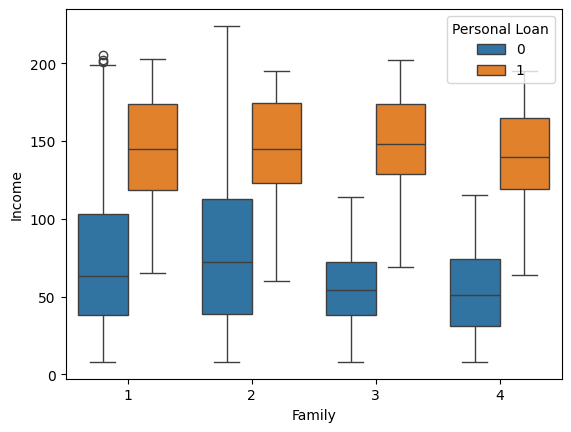

In [42]:
# the box plot showing the relationshion between family numbers and income categorised by personal loan status
sns.boxplot(x=df['Family'],y=df['Income'],hue=df['Personal Loan'])

In [43]:
# box plots of features
features = ['Age', 'Experience', 'Income', 'ZIP Code', 'Family', 'CCAvg', 'Education', 'Mortgage']
fig = make_subplots(rows=4, cols=2, subplot_titles=features)
for i, feature in enumerate(features, start=1):
    box_fig = px.box(df, x=feature)
    fig.add_trace(box_fig['data'][0], row=(i - 1) // 2 + 1, col=(i - 1) % 2 + 1)
fig.update_layout(title_text="Box Plots of Features", showlegend=False)
fig.show()

Overall, we can see that
1. CCavg and income exhibit a wider range, as indicated by their larger standard deviations.
2. the experience variable shows a distribution that includes negative values, which doesn't make sense and needs to be converted.
3. ZIP Code data has a outlier

## **3. Data Preparation**

### 3.1 Missing values

In [44]:
df.isnull().sum()

Age                   0
Experience            0
Income                0
ZIP Code              0
Family                0
CCAvg                 0
Education             0
Mortgage              0
Personal Loan         0
Securities Account    0
CD Account            0
Online                0
CreditCard            0
dtype: int64

In [45]:
df.nunique()

Age                    45
Experience             47
Income                162
ZIP Code              467
Family                  4
CCAvg                 108
Education               3
Mortgage              347
Personal Loan           2
Securities Account      2
CD Account              2
Online                  2
CreditCard              2
dtype: int64

In [46]:
df.describe()

Age   Experience       Income      ZIP Code       Family  \
count  5000.000000  5000.000000  5000.000000   5000.000000  5000.000000   
mean     45.338400    20.104600    73.774200  93152.503000     2.396400   
std      11.463166    11.467954    46.033729   2121.852197     1.147663   
min      23.000000    -3.000000     8.000000   9307.000000     1.000000   
25%      35.000000    10.000000    39.000000  91911.000000     1.000000   
50%      45.000000    20.000000    64.000000  93437.000000     2.000000   
75%      55.000000    30.000000    98.000000  94608.000000     3.000000   
max      67.000000    43.000000   224.000000  96651.000000     4.000000   

             CCAvg    Education     Mortgage  Personal Loan  \
count  5000.000000  5000.000000  5000.000000    5000.000000   
mean     23.255256     1.881000    56.498800       0.096000   
std      20.971908     0.839869   101.713802       0.294621   
min       0.000000     1.000000     0.000000       0.000000   
25%       8.400000     1.000000     0.000000       0.000000   
50%      18.000000     2.000000     0.000000       0.000000   
75%      30.000000     3.000000   101.000000       0.000000   
max     120.000000     3.000000   635.000000       1.000000   

       Securities Account  CD Account       Online   CreditCard  
count         5000.000000  5000.00000  5000.000000  5000.000000  
mean             0.104400     0.06040     0.596800     0.294000  
std              0.305809     0.23825     0.490589     0.455637  
min              0.000000     0.00000     0.000000     0.000000  
25%              0.000000     0.00000     0.000000     0.000000  
50%              0.000000     0.00000     1.000000     0.000000  
75%              0.000000     0.00000     1.000000     1.000000  
max              1.000000     1.00000     1.000000     1.000000

### 3.2 Negative values

The negative values in the "Experience" column likely result from potential data entry errors and need to be converted to positive values.

In [47]:
# count negative values in the 'Experience' column
negative_counts = df[df['Experience'] < 0]['Experience'].value_counts()

print('Negative values in the "Experience" column:')
for value, count in negative_counts.items():
    print(f'{value}: {count}')

Negative values in the "Experience" column:
-1: 33
-2: 15
-3: 4


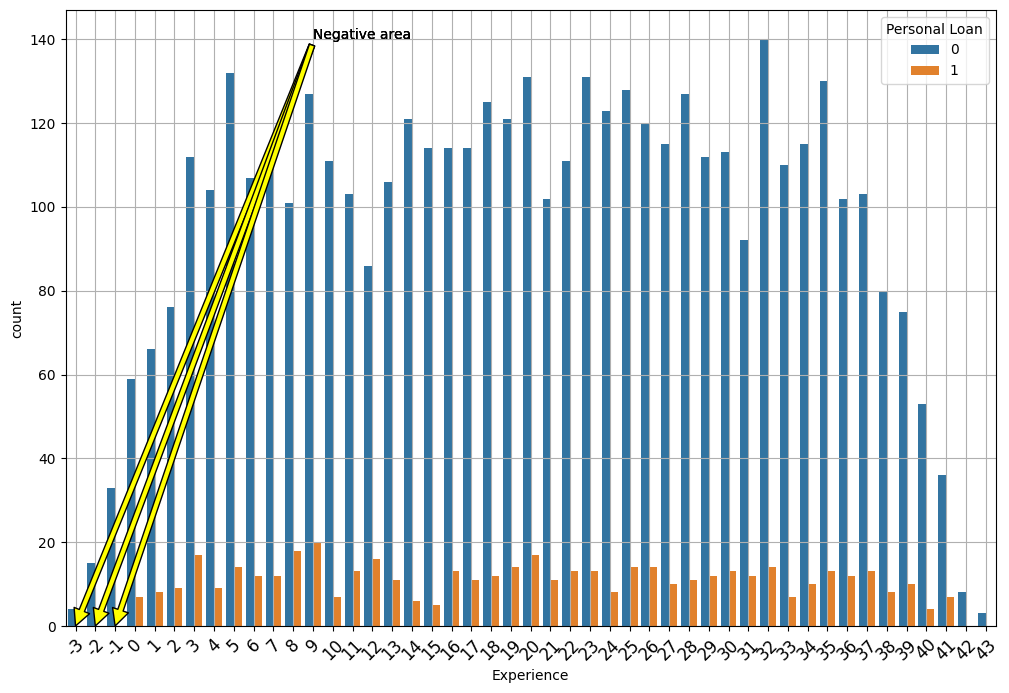

In [48]:
# plot count of 'Experience' with respect to 'Personal Loan'
plt.figure(figsize=(12, 8))
sns.countplot(x=df['Experience'], hue=df['Personal Loan'])

# annotate negative areas in the 'Experience' column
for x_coord in range(3):
    plt.annotate('Negative area', xy=(x_coord, 0), xytext=(12, 140), arrowprops=dict(facecolor="yellow", shrink=3))

plt.xticks(rotation=45, fontsize=12)
plt.grid()

In [49]:
# convert negative values in 'Experience' column to positive
df['Experience'] = abs(df['Experience'])
negative_experience_counts = df[df['Experience'] < 0]['Experience'].value_counts()

print("Counts of negative numbers after conversion:\n", negative_experience_counts)
print("All negative numbers have been converted to positive.")

Counts of negative numbers after conversion:
 Series([], Name: count, dtype: int64)
All negative numbers have been converted to positive.


### 3.3 Noise and outliers

Reduce noise for the ZIP Code input.

In [50]:
# noise filtering
noise = df[(df['ZIP Code']<90000)]
print(f"Number of rows with ZIP Code lower than 90000: {len(noise)}\n")
noise

Number of rows with ZIP Code lower than 90000: 1



Age  Experience  Income  ZIP Code  Family  CCAvg  Education  Mortgage  \
384   51          25      21      9307       4    7.2          3         0   

     Personal Loan  Securities Account  CD Account  Online  CreditCard  
384              0                   0           0       1           1

Text(0, 0.5, 'Personal Loan')

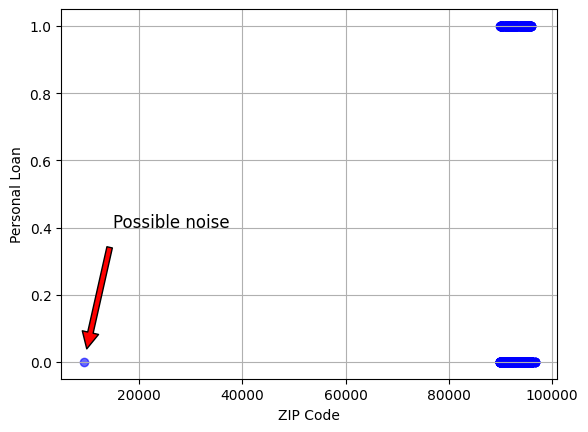

In [51]:
# potential noise point
plt.scatter(x=df['ZIP Code'], y=df['Personal Loan'], color='blue', alpha=0.6)
plt.annotate('Possible noise', xy=(9307, 0), xytext=(15000, 0.4),
             arrowprops=dict(facecolor="red", shrink=0.1), fontsize=12)
plt.grid(True)
plt.xlabel('ZIP Code')
plt.ylabel('Personal Loan')

In [52]:
# remove the noise
df.drop(index=[384],inplace=True)

Calculate the outliers based on Interquartile Range (IQR) method

In [53]:
df['Mortgage'].describe()

count    4999.000000
mean       56.510102
std       101.720837
min         0.000000
25%         0.000000
50%         0.000000
75%       101.000000
max       635.000000
Name: Mortgage, dtype: float64

In [54]:
# IQR
Q1 = df['Mortgage'].quantile(0.25)
Q3 = df['Mortgage'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR
print("Upper bound for outliers:", upper_bound)

Upper bound for outliers: 252.5


In [55]:
# calculate outlier range and impact (percentage)
upper_bound = 252.5
outliers = df[df['Mortgage'] > upper_bound]
num_outliers = len(outliers)
outlier_percentage = (num_outliers / len(df)) * 100
print(f"Number of outliers: {num_outliers}")
print(f"Percentage of outliers: {outlier_percentage:.2f}%")

Number of outliers: 291
Percentage of outliers: 5.82%


In [56]:
outliers['Mortgage'].describe()

count    291.000000
mean     355.663230
std       87.694277
min      253.000000
25%      292.500000
50%      328.000000
75%      401.000000
max      635.000000
Name: Mortgage, dtype: float64

Considering that the outliers are well-distributed and not clustered in an extreme area, also assuming that the data is correctly inputted, it is better to leave them in at this point to ensure the accuracy and authenticity of the data.

### 3.4 Mid-stage data visualisation

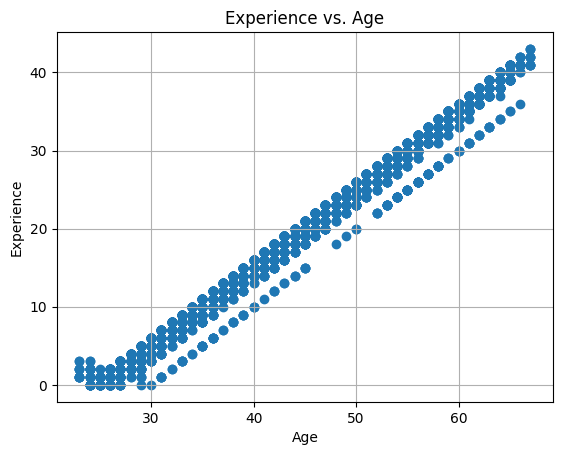

In [57]:
# the scatter plot showing relationship between age and professional experience
plt.scatter(x='Age', y='Experience', data=df)
plt.title('Experience vs. Age')
plt.xlabel('Age')
plt.ylabel('Experience')
plt.grid(True)
plt.show()

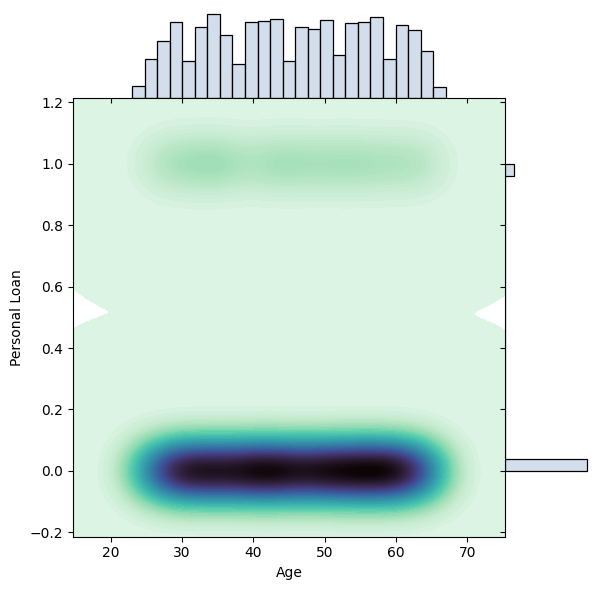

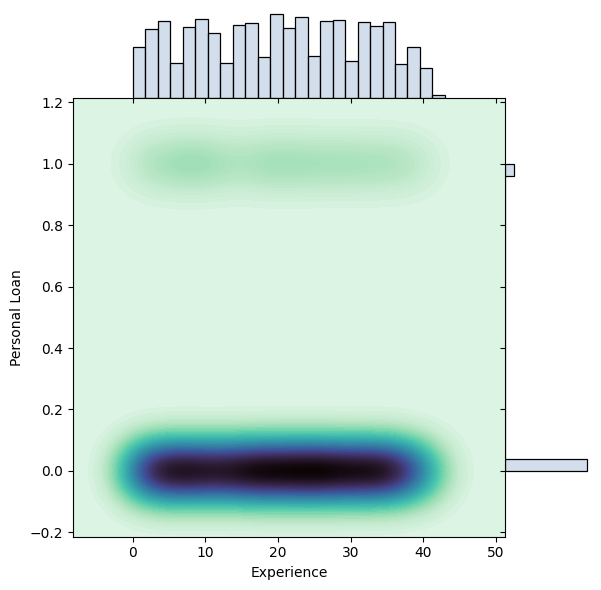

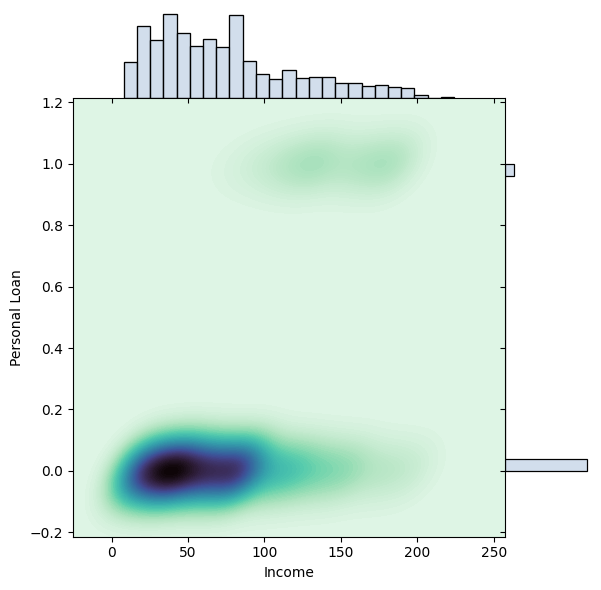

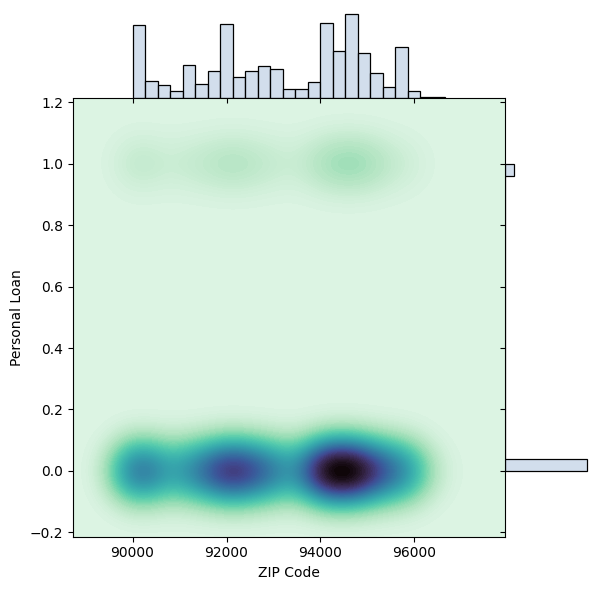

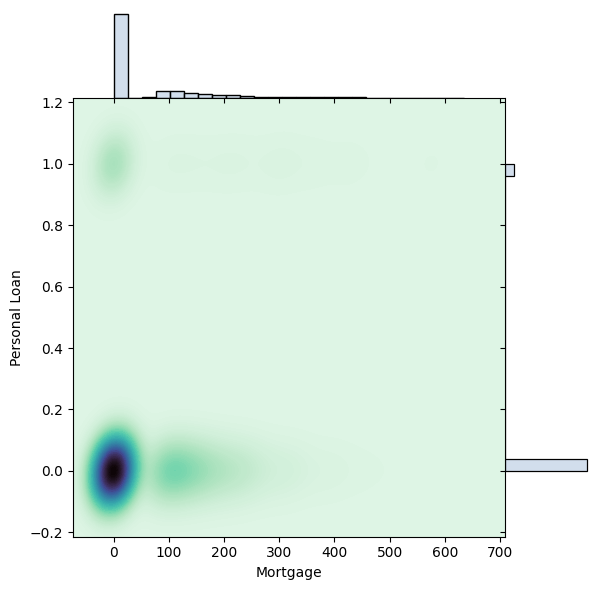

In [58]:
# joint plots showing the relationship between each feature and personal loan status
df_columns = ['Age', 'Experience', 'Income', 'ZIP Code', 'Mortgage']
for column in df_columns:
    g = sns.JointGrid(data=df, x=column, y='Personal Loan', space=0)
    g.plot_joint(sns.kdeplot, fill=True, thresh=0, levels=100, cmap="mako_r")  # KDE plot (joint distribution)
    g.plot_marginals(sns.histplot, color="#BFD1E5", alpha=0.7, bins=25)  #  histograms for marginal distribution

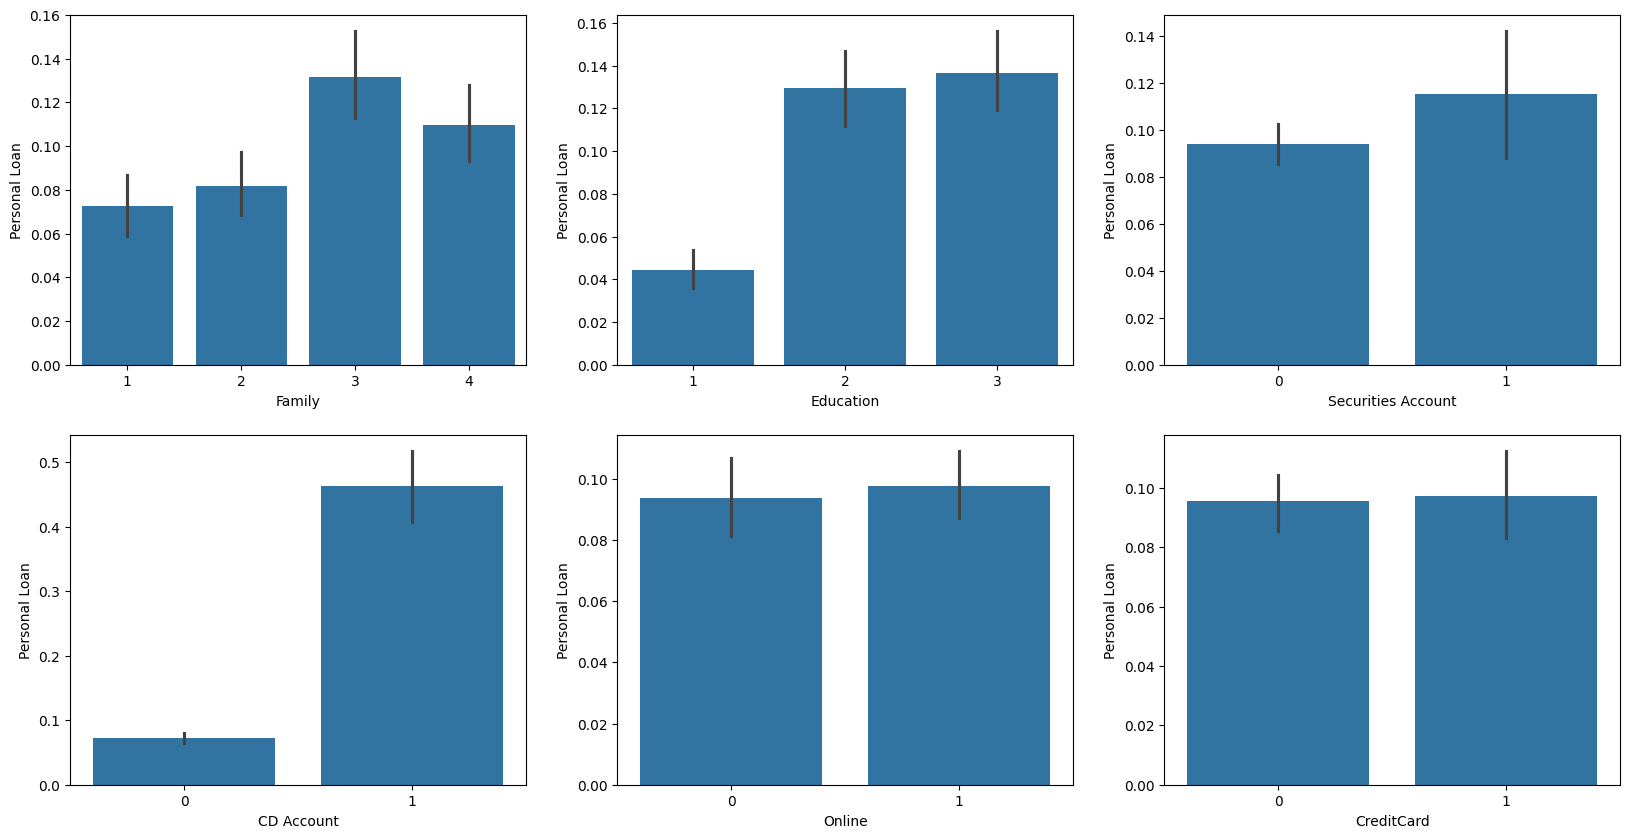

In [59]:
df_unique = ['Family', 'Education', 'Securities Account', 'CD Account', 'Online', 'CreditCard']
i = 0
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
for row in range(2):
    for col in range(3):
        sns.barplot(x=df_unique[i], y='Personal Loan', data=df, ax=axes[row, col]) # barplot
        i += 1

        if i == 6:
            break

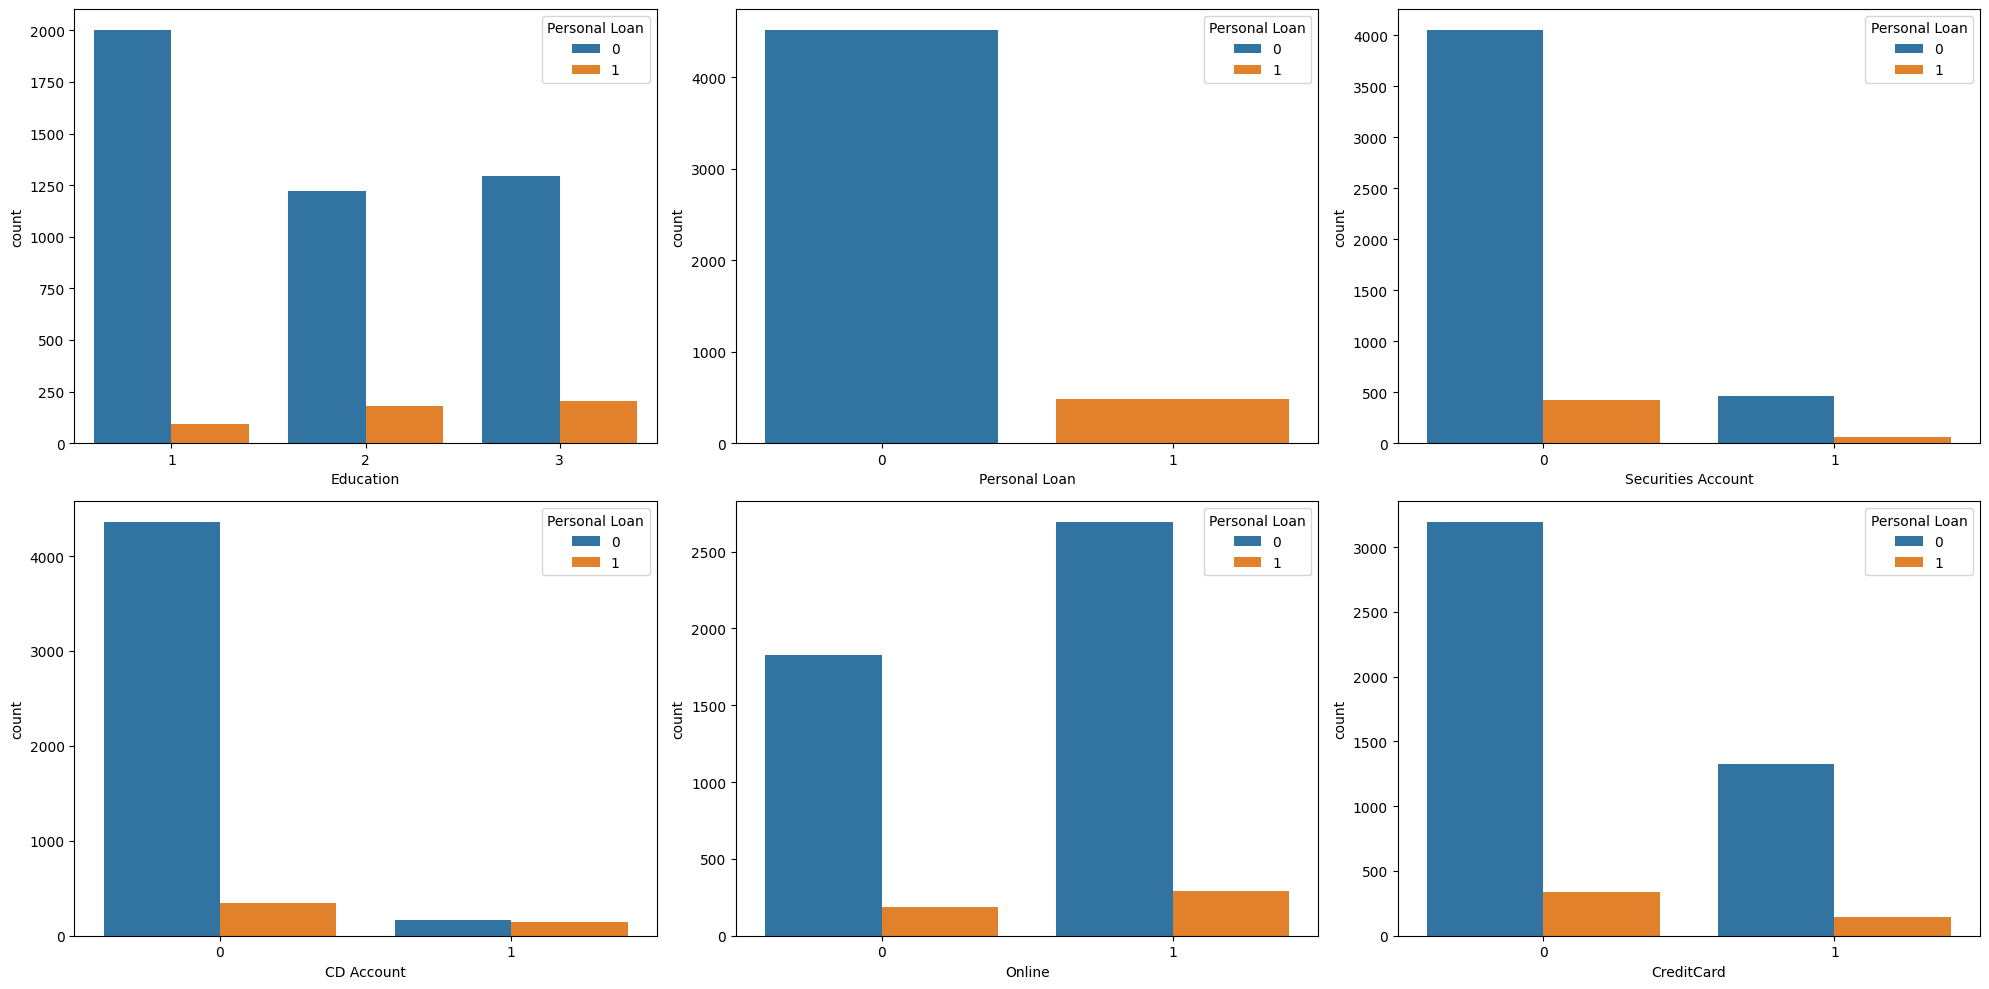

In [60]:
df_unique = ['Education', 'Personal Loan', 'Securities Account', 'CD Account', 'Online', 'CreditCard']
i = 0
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
for row in range(2):
    for col in range(3):
        sns.countplot(x=df_unique[i], hue='Personal Loan', data=df, ax=axes[row, col]) # countplot
        i += 1

        if i == 6:
            break
plt.tight_layout()
plt.show()

In [61]:
features = ['Age', 'Experience', 'Income', 'ZIP Code', 'Family', 'CCAvg', 'Education', 'Mortgage']

for feature in features:
    box_fig = px.box(df, x=feature, color='Personal Loan')
    box_fig.show()

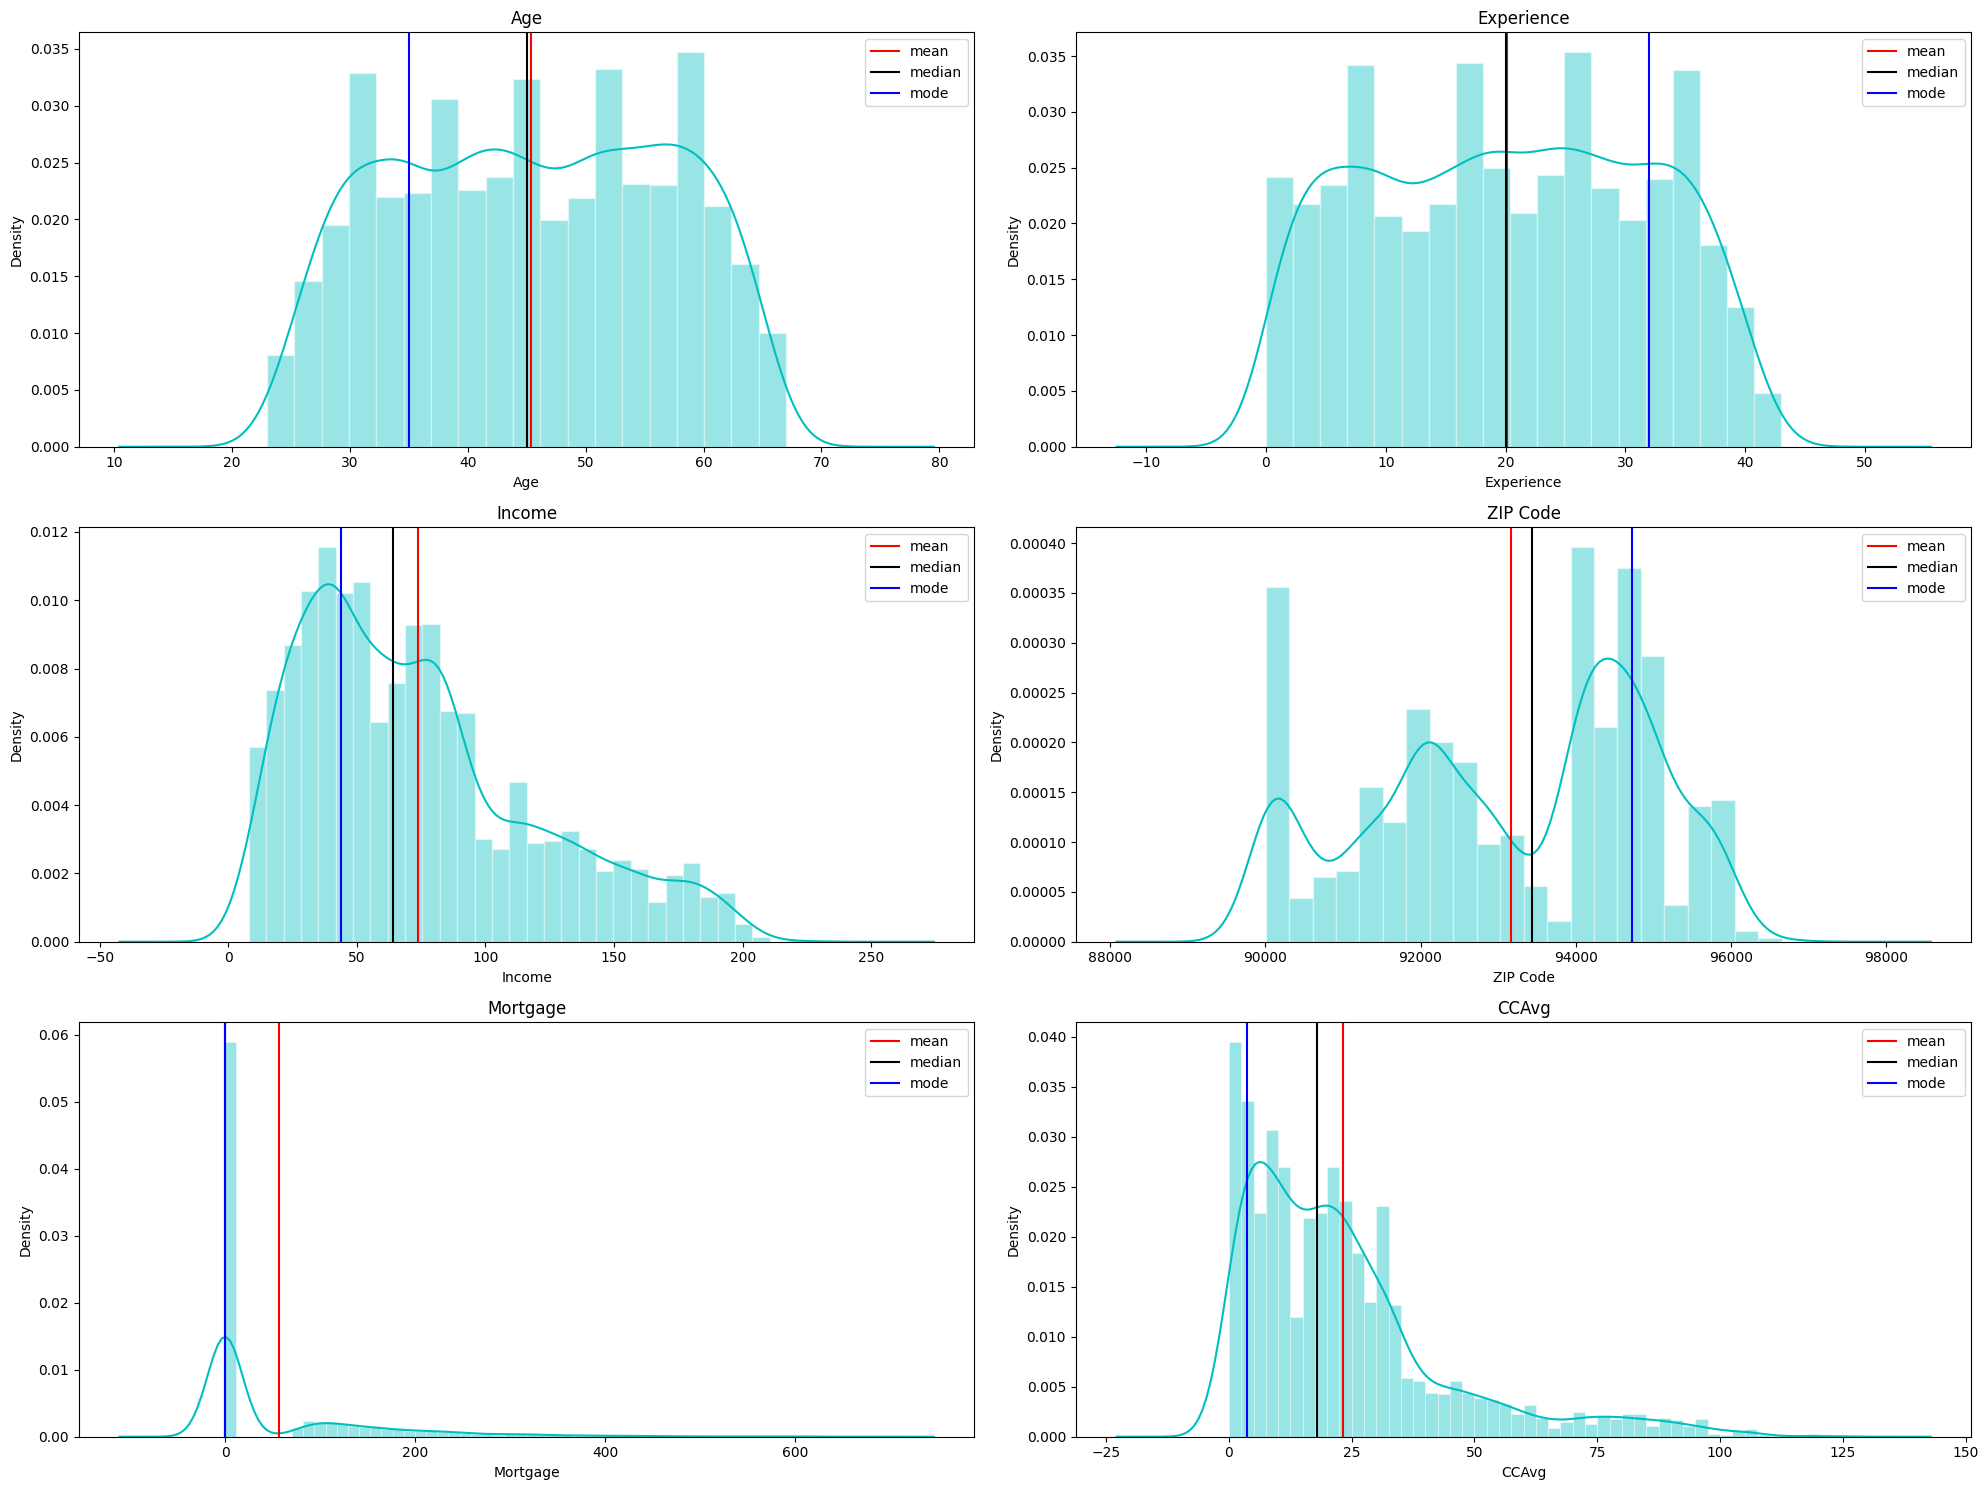

In [62]:
numcols = ['Age', 'Experience', 'Income', 'ZIP Code', 'Mortgage', 'CCAvg']
num_plots = len(numcols)
fig, axs = plt.subplots(3, 2, figsize=(20, 15))
axs = axs.flatten()

for i, col in enumerate(numcols):
    sns.histplot(df[col], color="c", kde=True,
                 stat="density", kde_kws=dict(cut=6),
                 alpha=.4, edgecolor=(1, 1, 1, .4), ax=axs[i]) # distribution plot (histogram)
    # 3 vertical lines - mean, median, mode
    axs[i].axvline(df[col].mean(), label='mean', color='red')
    axs[i].axvline(df[col].median(), label='median', color='black')
    axs[i].axvline(df[col].mode()[0], label='mode', color='blue')
    axs[i].set_title(col)
    axs[i].legend()
# remove excess plots
for j in range(num_plots, 3 * 2):
    fig.delaxes(axs[j])
plt.tight_layout()

### 3.5 ZIP Code

#### **3.5.1 ZIP Code conversion**

In [63]:
# 1. extract ZIP codes
list_zipcode = list(df['ZIP Code'])
country = []
lat = []
long = []
# 2. retrieve city and county information
for x in list_zipcode:
    my_city_county = zcode.matching(str(x))
    # check if only one city and county match is found
    if len(my_city_county) == 1:
        County = my_city_county[0].get('county')
        Lat = my_city_county[0].get('lat')
        Long = my_city_county[0].get('long')
    else:
    # if multiple or no matches are found, mark as 'not found'
        County = 'not found'
        Lat = np.NaN
        Long = np.NaN
    country.insert(0, County)
    lat.insert(0, Lat)
    long.insert(0, Long)
# 3. reverse the lists to match df's original order
country.reverse()
lat.reverse()
long.reverse()
# 4. store the information to df
df['Place'] = country
df['Latitude'] = lat
df['Longitude'] = long

In [64]:
df.sample(5, random_state=42)

Age  Experience  Income  ZIP Code  Family  CCAvg  Education  Mortgage  \
84     46          22      18     91730       1   10.8          3         0   
2471   36          11      44     91040       2   13.2          2        85   
2805   37          12     182     94523       3   69.6          3         0   
4988   34           8      85     95134       1   30.0          1       136   
4925   64          39      82     94025       4   40.8          2         0   

      Personal Loan  Securities Account  CD Account  Online  CreditCard  \
84                0                   0           0       1           0   
2471              0                   0           0       1           0   
2805              1                   0           0       1           0   
4988              0                   0           0       0           1   
4925              0                   0           0       1           0   

                      Place Latitude  Longitude  
84    San Bernardino County  34.0994  -117.5763  
2471     Los Angeles County  34.2853  -118.3145  
2805    Contra Costa County  37.9538  -122.0778  
4988     Santa Clara County  37.4248  -121.9460  
4925       San Mateo County  37.4590  -122.1861

In [65]:
df[['Place', 'Latitude', 'Longitude']].describe()

Place Latitude  Longitude
count                 4999     4966       4966
unique                  39      451        451
top     Los Angeles County  37.8746  -122.2547
freq                  1095      169        169

#### **3.5.2 Missing values**

In [66]:
df.loc[df['Latitude'].isna() | df['Longitude'].isna(), ['Place','Latitude', 'Longitude']]

Place Latitude Longitude
106   not found      NaN       NaN
172   not found      NaN       NaN
184   not found      NaN       NaN
321   not found      NaN       NaN
366   not found      NaN       NaN
468   not found      NaN       NaN
476   not found      NaN       NaN
630   not found      NaN       NaN
672   not found      NaN       NaN
695   not found      NaN       NaN
721   not found      NaN       NaN
780   not found      NaN       NaN
1099  not found      NaN       NaN
1189  not found      NaN       NaN
1426  not found      NaN       NaN
1483  not found      NaN       NaN
1653  not found      NaN       NaN
1752  not found      NaN       NaN
1844  not found      NaN       NaN
2049  not found      NaN       NaN
2211  not found      NaN       NaN
2218  not found      NaN       NaN
2428  not found      NaN       NaN
2486  not found      NaN       NaN
2731  not found      NaN       NaN
2957  not found      NaN       NaN
3525  not found      NaN       NaN
3887  not found      NaN       NaN
4090  not found      NaN       NaN
4276  not found      NaN       NaN
4321  not found      NaN       NaN
4384  not found      NaN       NaN
4392  not found      NaN       NaN

In [67]:
df.isnull().sum()

Age                    0
Experience             0
Income                 0
ZIP Code               0
Family                 0
CCAvg                  0
Education              0
Mortgage               0
Personal Loan          0
Securities Account     0
CD Account             0
Online                 0
CreditCard             0
Place                  0
Latitude              33
Longitude             33
dtype: int64

In [68]:
df[df['Place']=='not found']['ZIP Code'].value_counts()

ZIP Code
92717    22
96651     6
92634     5
Name: count, dtype: int64

For locations not previously found, I'll manually fill in the details (place, longitude & latitude). Here are the corresponding places for each zip code:

*   92717: Irvine
*   92634: Fullerton
*   96651: Rudno nad Hronom

Based on this, it seems that only 96651 is not located in the US, but rather in Slovakia. Assuming the data entry is accurate, I'll leave it unchanged.

---
The latitude and longitude I retrieved are from the following websites:

*   92717 - http://m.postcode.info/en/united-states/p/92717
*   92634 - http://m.postcode.info/en/united-states/p/92634
*   96651 - https://worldpostalcode.com/lookup



In [69]:
# 92717
z_code92717 = df[df['ZIP Code'] == 92717].index
for i in z_code92717:
    df.at[i, 'Place'] = 'Irvine'
    df.at[i, 'Latitude'] = 33.6462
    df.at[i, 'Longitude'] = -117.8398
df[df['ZIP Code'] == 92717].style.highlight_max(color='green', axis=1, subset=['Personal Loan'])

In [70]:
# 92634
z_code92634 = list(df[df['ZIP Code'] == 92634].index)
for i in z_code92634:
    df.at[i, 'Place'] = 'Fullerton'
    df.at[i, 'Latitude'] = 33.8739
    df.at[i, 'Longitude'] = -117.9028
df[df['ZIP Code'] == 92634].style.highlight_max(color='green', axis=1, subset=['Personal Loan'])

In [71]:
# 96651
z_code96651 = list(df[df['ZIP Code'] == 96651].index)
for i in z_code96651:
    df.at[i, 'Place'] = 'Rudno nad Hronom'
    df.at[i, 'Latitude'] = 48.4308
    df.at[i, 'Longitude'] = 18.6843
df[df['ZIP Code'] == 96651].style.highlight_max(color='green', axis=1, subset=['Personal Loan'])

In [72]:
# the geographic coordinate range of inputted locations
df = df.astype({'Latitude': float, 'Longitude': float})
print('min:', df.Longitude.min())
print('max:', df.Longitude.max())
print('min:', df.Latitude.min())
print('max:', df.Latitude.max())

min: -124.0994
max: 18.6843
min: 32.5547
max: 48.4308


### 3.6 Post-stage data visualisation

Visualise the regional distribution based on personal loan status. And the image depicts the geographical locations of individuals with personal loans.

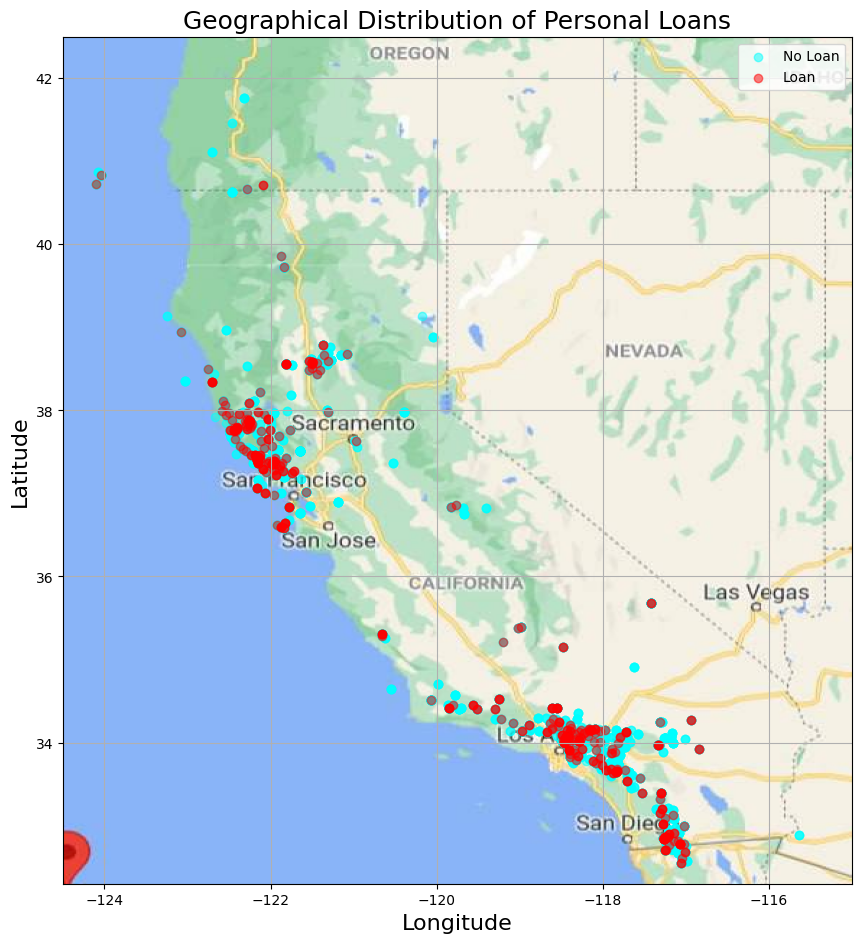

In [73]:
# regional distribution
target_0 = df[df['Personal Loan'] == 0]
target_1 = df[df['Personal Loan'] == 1]
img = plt.imread('IMG_7580.jpeg')
plt.figure(figsize=(16, 11))
plt.scatter(target_0['Longitude'], target_0['Latitude'], c='cyan', label='No Loan', alpha=0.5)
plt.scatter(target_1['Longitude'], target_1['Latitude'], c='red', label='Loan', alpha=0.5)
plt.imshow(img, extent=[-124.5, -115, 32.3, 42.5])
plt.legend(loc='best')
plt.grid()
plt.xlabel('Longitude', fontsize=16)
plt.ylabel('Latitude', fontsize=16)
plt.title('Geographical Distribution of Personal Loans', fontsize=18)
plt.show()

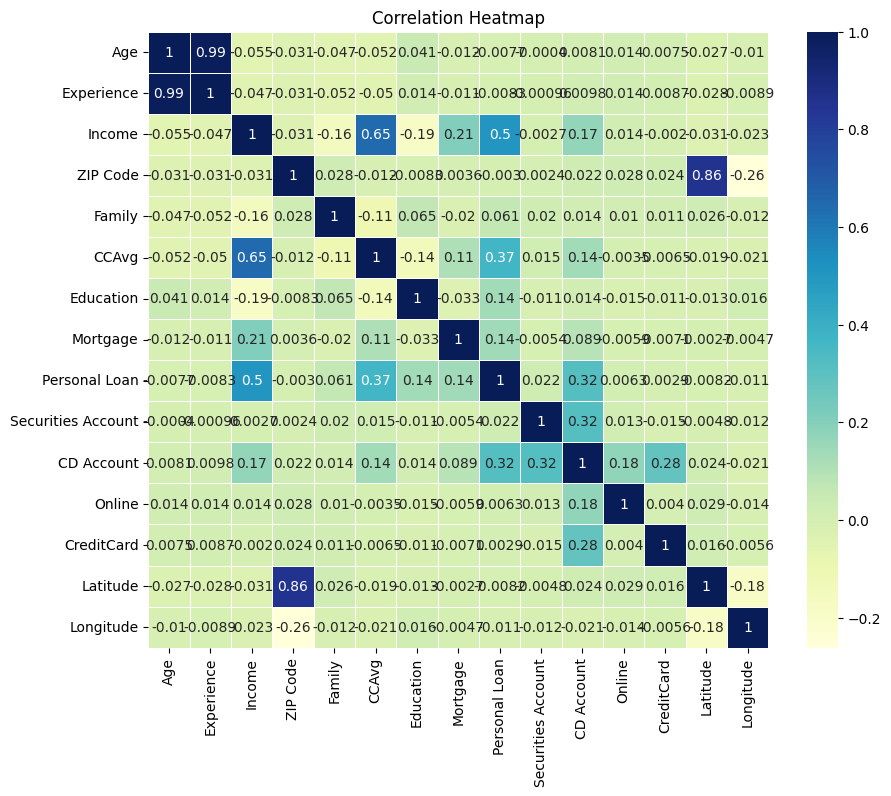

In [74]:
# correlation heatmap
correlation_matrix = df.drop(columns=['Place']).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='YlGnBu', annot=True, linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

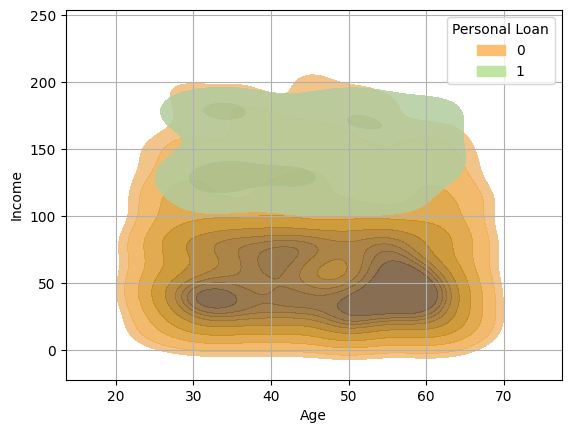

In [75]:
# KDE plot showing the relationship between age and income, categorised by personal loan status
sns.kdeplot(data=df, x='Age', y='Income', hue='Personal Loan', palette='Spectral', alpha=0.85, fill=True)
plt.grid(True)
plt.show()

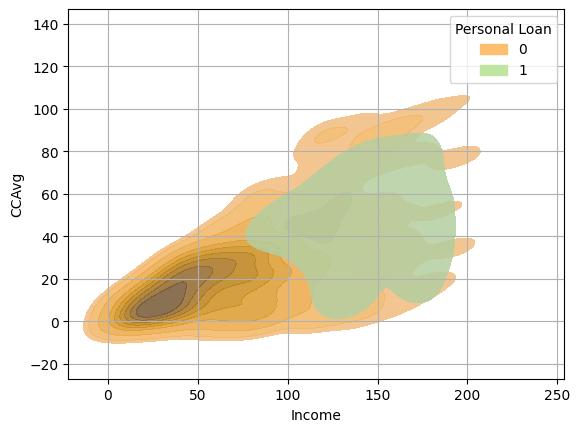

In [76]:
# KDE plot showing the relationship between average annual credit card spending and income, categorised by personal loan status
sns.kdeplot(data=df, x='Income', y='CCAvg', hue='Personal Loan', palette='Spectral', alpha=0.85, fill=True)
plt.grid(True)
plt.show()

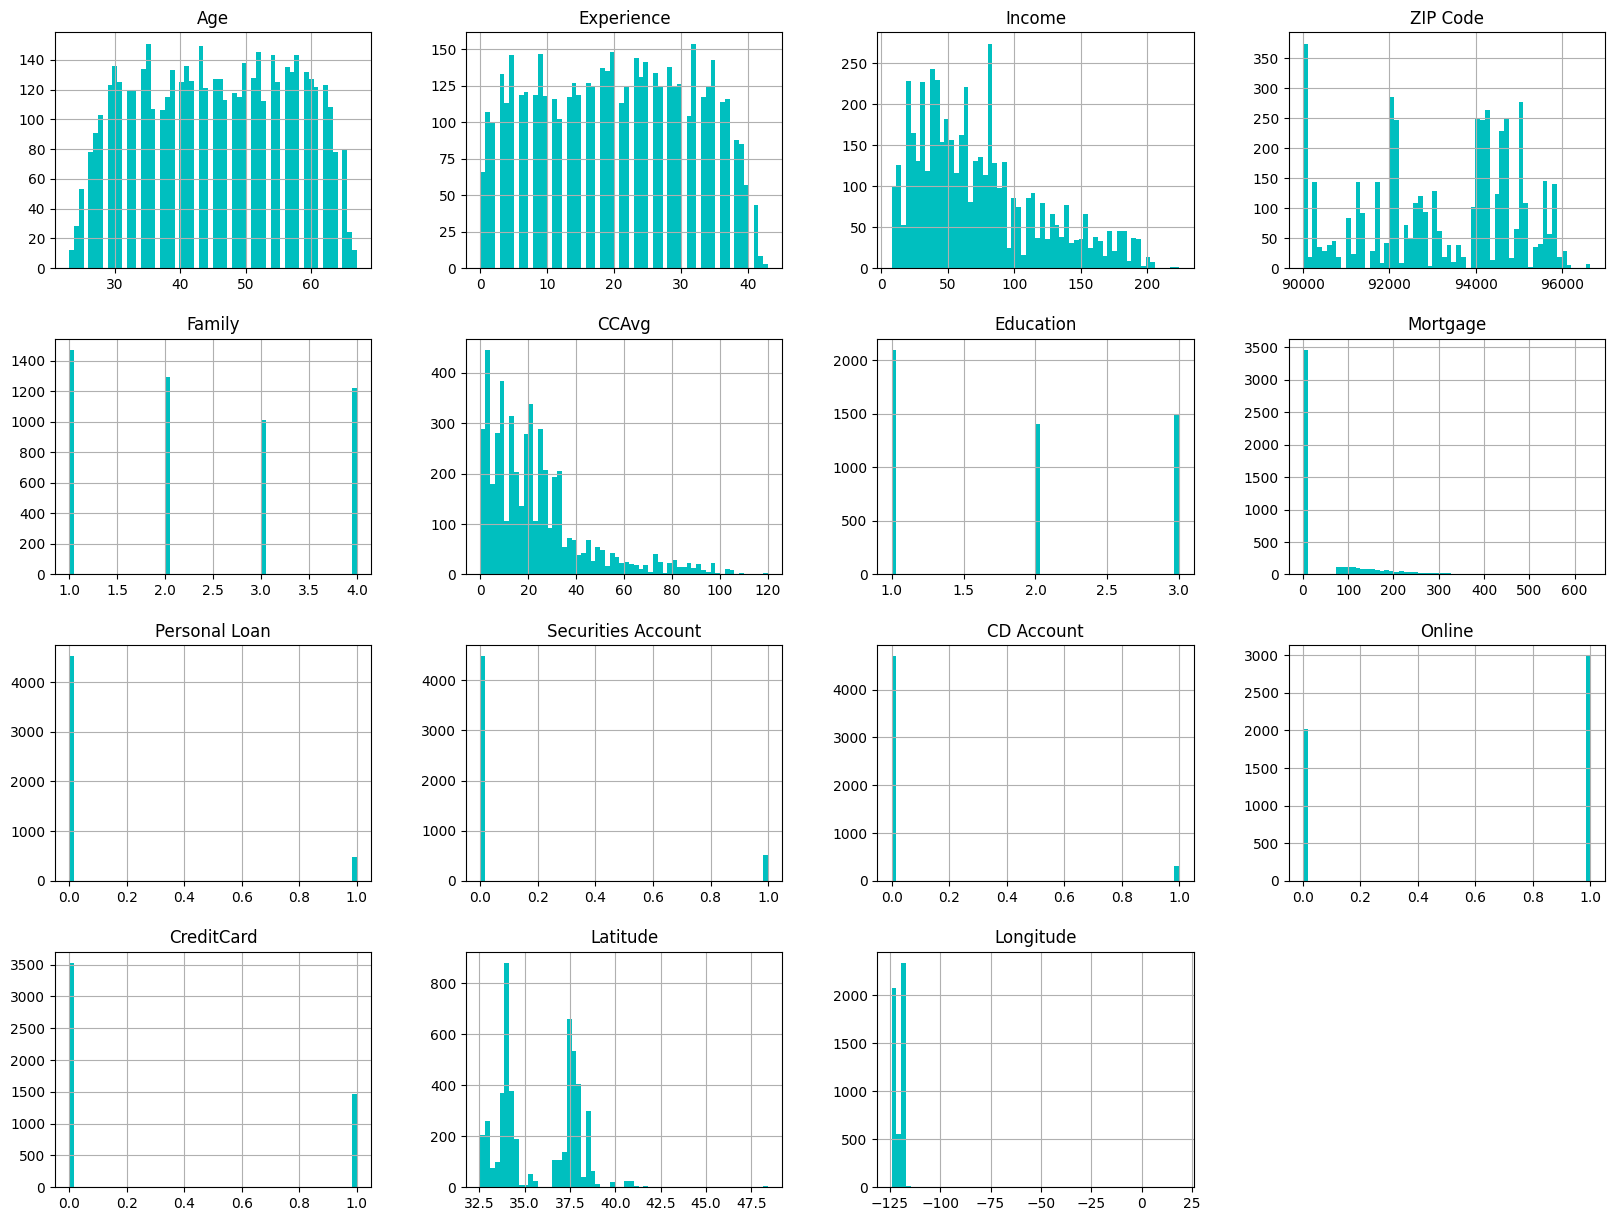

In [77]:
# histogram
df.hist(bins=60,figsize=(20,15),color='c')
plt.show()

In [78]:
df.describe()

Age   Experience       Income      ZIP Code       Family  \
count  4999.000000  4999.000000  4999.000000   4999.000000  4999.000000   
mean     45.337267    20.133627    73.784757  93169.275455     2.396079   
std      11.464033    11.416124    46.032281   1759.630610     1.147554   
min      23.000000     0.000000     8.000000  90005.000000     1.000000   
25%      35.000000    10.000000    39.000000  91911.000000     1.000000   
50%      45.000000    20.000000    64.000000  93437.000000     2.000000   
75%      55.000000    30.000000    98.000000  94608.000000     3.000000   
max      67.000000    43.000000   224.000000  96651.000000     4.000000   

             CCAvg    Education     Mortgage  Personal Loan  \
count  4999.000000  4999.000000  4999.000000    4999.000000   
mean     23.258468     1.880776    56.510102       0.096019   
std      20.972776     0.839804   101.720837       0.294647   
min       0.000000     1.000000     0.000000       0.000000   
25%       8.400000     1.000000     0.000000       0.000000   
50%      18.000000     2.000000     0.000000       0.000000   
75%      30.000000     3.000000   101.000000       0.000000   
max     120.000000     3.000000   635.000000       1.000000   

       Securities Account   CD Account       Online   CreditCard     Latitude  \
count         4999.000000  4999.000000  4999.000000  4999.000000  4999.000000   
mean             0.104421     0.060412     0.596719     0.293859    35.795917   
std              0.305836     0.238273     0.490605     0.455574     2.142817   
min              0.000000     0.000000     0.000000     0.000000    32.554700   
25%              0.000000     0.000000     0.000000     0.000000    34.001800   
50%              0.000000     0.000000     1.000000     0.000000    35.301700   
75%              0.000000     0.000000     1.000000     1.000000    37.748700   
max              1.000000     1.000000     1.000000     1.000000    48.430800   

         Longitude  
count  4999.000000  
mean   -119.859538  
std       5.238974  
min    -124.099400  
25%    -122.148500  
50%    -119.847500  
75%    -118.077200  
max      18.684300

## **4. Modelling**

### 4.1 Feature vector & target variable

In [79]:
# drop the target column & 'Place' column, which have been quantified with the 'Longitude' and 'Latitude' columns
X = df.drop(['Personal Loan', 'Place'], axis=1)
y = df['Personal Loan']

### 4.2 Data splitting into traning and testing sets

In [80]:
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [81]:
# check the shape of X_train and X_test
X_train.shape, X_test.shape

((3999, 14), (1000, 14))

### 4.3 Feature scalling

In [82]:
cols = X_train.columns
# Use StandardScaler instead of MinMaxScaler to mitigate the model's sensitivity to outliers
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=[cols])
X_test = pd.DataFrame(X_test, columns=[cols])

### 4.4 SVM with default hyperparameters (RBF)

#### **4.4.1 Model training and accuracy check**

In [83]:
# default hyperparameters
svc=SVC()
svc.fit(X_train,y_train) # fit classifier to training set
y_pred_test=svc.predict(X_test) # predictions on test set
# print accuracy score
print(f"Model accuracy score using default hyperparameters:\033[1m {accuracy_score(y_test, y_pred_test):.4f}\033[0m")

Model accuracy score using default hyperparameters: 0.9650


In this step, owing to the presence of outliers and the uncertainty inherent in this dataset, we try to increase the value of C to narrow the margin and enhance the decision boundary. Then, we will see if a higher C value results in increased accuracy through multi-model application.

In [84]:
# rbf kernel and C=100
svc100=SVC(C=100.0)
svc100.fit(X_train,y_train)
y_pred=svc100.predict(X_test)
print(f"Model accuracy score using rbf kernel and C=100.0 :\033[1m {accuracy_score(y_test, y_pred):.4f}\033[0m")

Model accuracy score using rbf kernel and C=100.0 : 0.9750


It is apparent that the accuracy increases as we raise the value of C. We'll continue to increase C to ensure that the decision boundary considers more data points, making it more tolerant of outliers.

In [85]:
# rbf kernel and C=1000
svc1000=SVC(C=1000.0)
svc1000.fit(X_train,y_train)
y_pred=svc1000.predict(X_test)
print(f"Model accuracy score using rbf kernel and C=1000.0 :\033[1m {accuracy_score(y_test, y_pred):.4f}\033[0m")

Model accuracy score using rbf kernel and C=1000.0 : 0.9740


The testing results indicate that the model's accuracy decreases with C = 1000 for the RBF kernel.

In the accuracy calculation, y_test shows the actual categories, while y_pred shows the guessed ones in the test group.

#### **4.4.2 Evaluating model fit: overfitting and underfitting**

Now, let's compare the accuracy of the training and testing sets to see if there's any overfitting.

In [86]:
# this result is comparable with the testing result
y_pred_train = svc.predict(X_train)
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))

Training-set accuracy score: 0.9802


In [87]:
# compare the train-set and test-set accuracy
print('Training set score: {:.4f}'.format(svc.score(X_train, y_train)))
print('Test set score: {:.4f}'.format(svc.score(X_test, y_test)))

Training set score: 0.9802
Test set score: 0.9650


The scores show that the model works well on both the training and test data. The high score on the training data means it learned the patterns well. The test score, although a bit lower, is still high, showing it works well on new data too.

---

Since both scores are close and high, it means the model fits well and doesn't memorise the training data too much. So, there is no overfitting or underfitting in this model.

#### **4.4.3 Performance assessment: Null accuracy**



Our model's accuracy stands at 0.9750. However, this figure alone doesn't guarantee its effectiveness. To assess the performance, we compare it against the null accuracy. Null accuracy represents the accuracy achieved by always predicting the most frequent class.

In [88]:
# class distribution of the test set
y_test.value_counts()

Personal Loan
0    899
1    101
Name: count, dtype: int64

The most frequent class, class 0, occurs 899 times. Therefore, we can calculate the null accuracy by dividing 899 by the total number of occurrences.

In [89]:
# null accuracy score
null_accuracy = (899/(899+101))
print('Null accuracy score: {0:0.4f}'. format(null_accuracy))

Null accuracy score: 0.8990


Our SVM classifier gets a score of 0.9750, while the null accuracy score is 0.8991. This means our model is pretty good at predicting class labels.

### 4.5 SVM with linear kernel

In [90]:
# linear kernel and C=1.0
linear_svc=SVC(kernel='linear', C=1.0)
linear_svc.fit(X_train,y_train) # fit classifier to training set
y_pred=linear_svc.predict(X_test) # prediction
# print accuracy score
print(f"Model accuracy score using linear kernel and C=1.0 :\033[1m {accuracy_score(y_test, y_pred):.4f}\033[0m")

Model accuracy score using linear kernel and C=1.0 : 0.9430


In [91]:
# linear kernel and C=100.0
linear_svc100=SVC(kernel='linear', C=100.0)
linear_svc100.fit(X_train, y_train)
y_pred=linear_svc100.predict(X_test)
print(f"Model accuracy score using linear kernel and C=100.0 :\033[1m {accuracy_score(y_test, y_pred):.4f}\033[0m")

Model accuracy score using linear kernel and C=100.0 : 0.9430


In [92]:
# linear kernel and C=1000.0
linear_svc1000=SVC(kernel='linear', C=1000.0)
linear_svc1000.fit(X_train, y_train)
y_pred=linear_svc1000.predict(X_test)
print(f"Model accuracy score using linear kernel and C=1000.0 :\033[1m {accuracy_score(y_test, y_pred):.4f}\033[0m")

Model accuracy score using linear kernel and C=1000.0 : 0.9420


The linear kernel's performance is poorer compared to the RBF kernel's, and we observe that the performances with C = 100 are better than with C = 1000.

### 4.6 SVM with polynomial kernel

In [93]:
# polynomial kernel and C=1.0
poly_svc=SVC(kernel='poly', C=1.0)
poly_svc.fit(X_train,y_train) # fit classifier to training set
y_pred=poly_svc.predict(X_test) # prediction
# print accuracy score
print(f"Model accuracy score using polynomial kernel and C=1.0 :\033[1m {accuracy_score(y_test, y_pred):.4f}\033[0m")

Model accuracy score using polynomial kernel and C=1.0 : 0.9590


In [94]:
# polynomial kernel and C=100.0
poly_svc100=SVC(kernel='poly', C=100.0)
poly_svc100.fit(X_train,y_train)
y_pred=poly_svc100.predict(X_test)
print(f"Model accuracy score using polynomial kernel and C=100.0 :\033[1m {accuracy_score(y_test, y_pred):.4f}\033[0m")

Model accuracy score using polynomial kernel and C=100.0 : 0.9620


So far, the rbf kernel's performance is the best with C = 100. We can see poloynomial's model performace outperforms the linear's one.

### 4.7 SVM with sigmoid kernel

In [95]:
# sigmoid kernel and C=1.0
sigmoid_svc=SVC(kernel='sigmoid', C=1.0)
sigmoid_svc.fit(X_train,y_train) # fit classifier to training set
y_pred=sigmoid_svc.predict(X_test) # prediction
# print accuracy score
print(f"Model accuracy score using sigmoid kernel and C=1.0 :\033[1m {accuracy_score(y_test, y_pred):.4f}\033[0m")

Model accuracy score using sigmoid kernel and C=1.0 : 0.8960


In [96]:
# sigmoid kernel and C=100.0
sigmoid_svc100=SVC(kernel='sigmoid', C=100.0)
sigmoid_svc100.fit(X_train,y_train)
y_pred=sigmoid_svc100.predict(X_test)
print(f"Model accuracy score using sigmoid kernel and C=100.0 :\033[1m {accuracy_score(y_test, y_pred):.4f}\033[0m")

Model accuracy score using sigmoid kernel and C=100.0 : 0.8980


## **5. Evaluation**

### 5.1 Confusion matrix


We now have the highest accuracy of 0.9750 with the rbf kernel and C=100.0, suggesting our classification model works well. But, this conclusion might not hold true because our dataset is imbalanced (skewed distribution).

Accuracy alone isn't reliable for evaluating predictive performance in such cases. Hence, we need to consider alternative metrics, like the confusion matrix, to better understand our model's performance and the types of errors it makes in imbalanced datasets.

In [97]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
print(f'Confusion matrix:\n\n{cm}\n')
print(f'True Positives(TP) = {cm[0,0]}\n')
print(f'True Negatives(TN) = {cm[1,1]}\n')
print(f'False Positives(FP) = {cm[0,1]}\n')
print(f'False Negatives(FN) = {cm[1,0]}\n')

Confusion matrix:

[[896   3]
 [ 32  69]]

True Positives(TP) = 896

True Negatives(TN) = 69

False Positives(FP) = 3

False Negatives(FN) = 32



<Axes: >

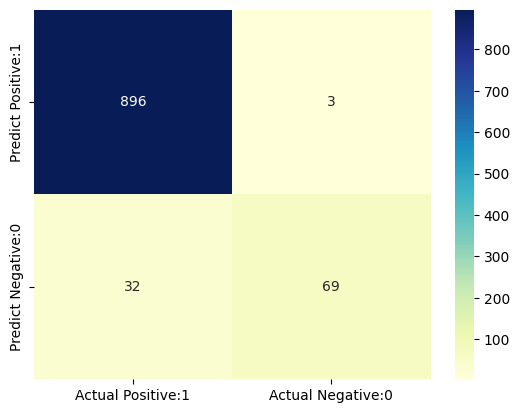

In [98]:
# visualize confusion matrix with seaborn heatmap
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'],
                                 index=['Predict Positive:1', 'Predict Negative:0'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

### 5.2 Classification metrics

In [99]:
# classification report
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       899
           1       0.96      0.68      0.80       101

    accuracy                           0.96      1000
   macro avg       0.96      0.84      0.89      1000
weighted avg       0.96      0.96      0.96      1000



**Metrics explanation**
- Precision: 97% of the instances predicted as "personal loan = 0" were correct, while 96% of those predicted as "personal loan = 1" were correct.
- Recall: 100% of the actual "personal loan = 0" instances were predicted correctly, while 68% of the actual "personal loan = 1" instances were predicted correctly.
- F1-score: The harmonic mean of precision and recall is 98% for "personal loan = 0" and 80% for "personal loan = 1".
- Accuracy: The overall accuracy of the model is 96%, meaning it correctly predicts personal loan status for 96% of the instances.
- Macro avg: The average precision, recall, and F1-score across both classes are 96%, 84%, and 89% respectively.
- Weighted avg: The weighted average precision, recall, and F1-score, considering class imbalance, are also 96%, 96%, and 96% respectively.
- Support represents the actual frequency of the class occurrences in our dataset.

In [100]:
# True Positives (TP), True Negatives (TN), False Positives (FP), and False Negatives (FN)
TP = cm[0, 0]
TN = cm[1, 1]
FP = cm[0, 1]
FN = cm[1, 0]

# classification accuracy
classification_accuracy = (TP + TN) / (TP + TN + FP + FN)
print(f'Classification accuracy: {classification_accuracy:.4f}')

Classification accuracy: 0.9650


Overall, the model performs well in predicting cases where people don't take personal loans, but it's a bit less accurate in predicting cases where they do.

In [101]:
# classification error
classification_error = (FP + FN) / float(TP + TN + FP + FN)
print(f'Classification error : {classification_error:.4f}')

Classification error : 0.0350


### 5.3 ROC - AUC

#### **5.3.1 ROC Curve**

The ROC Curve (Receiver Operating Characteristic Curve) is a visual tool to assess how well a classification model performs across different threshold levels.

It plots the True Positive Rate (Recall) against the False Positive Rate at various thresholds.

The True Positive Rate is the ratio of correctly predicted positive instances to all actual positives, while the False Positive Rate is the ratio of incorrectly predicted positives to all actual negatives.

---

By looking at the ROC Curve, we can see how well the model identifies positives while avoiding false alarms at different decision points (so-called classification threshold levels). Changing these decision points can affect how many things are flagged as positive, which impacts both correct identifications and false alarms.

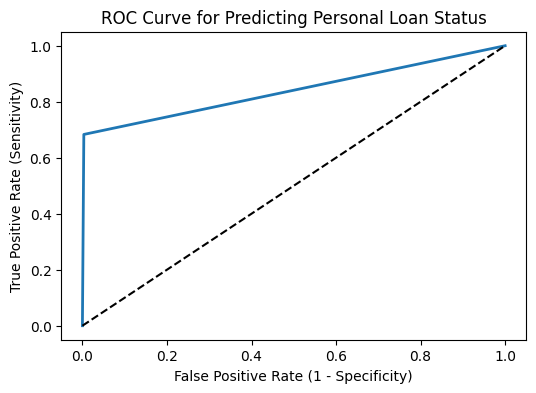

In [102]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1], [0,1], 'k--' )
plt.title('ROC Curve for Predicting Personal Loan Status')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.show()

The ROC curve helps us find the right threshold level that balances catching the positives (sensitivity) and avoiding false alarms (specificity) in a given situation.

#### **5.3.2 ROC AUC**

ROC AUC, short for Receiver Operating Characteristic - Area Under Curve, is a way to compare how well classifiers work. We'll look at the area under the curve (AUC).

If a classifier is perfect, its ROC AUC will be 1, but if it's random, the ROC AUC will be 0.5.

So, ROC AUC tells us the proportion of the ROC plot that's under the curve.

In [103]:
# ROC AUC
roc_auc = roc_auc_score(y_test, y_pred_test)
print(f'ROC AUC: {roc_auc:.4}')

ROC AUC: 0.8399


A higher ROC AUC value means a better classifier.

Our model's ROC AUC score is considered good as 0.8399, indicating it does a good job at predicting personal loans."

In [104]:
# cross-validated ROC AUC
cross_val_ROC_AUC = cross_val_score(svc, X_train, y_train, cv=10, scoring='roc_auc').mean()
print(f'Cross-validated ROC AUC score: {cross_val_ROC_AUC:.4}')

Cross-validated ROC AUC score: 0.9841


### 5.4 Stratified k-fold Cross-Validation with shuffle split

Why choosing Stratified k-fold?


*  This dataset includes 4519 individuals without a personal loan and 480 individuals with a personal loan.

*  Since it's an imbalanced dataset, using Stratified k-fold cross-validation ensures that each fold maintains the original class distribution. This is important for getting accurate performance estimates, especially for the class without a personal loan in this case.

*  Hence, Stratified k-fold cross-validation is a superior method compared to k-fold for this imbalanced dataset.








In [105]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# rbf kernel
rbf_svm = SVC(kernel='rbf')
rbf_scores = cross_val_score(rbf_svm, X, y, cv=skf)
print(f'Stratified Cross-validation scores with rbf kernel:\n\n{rbf_scores}')

Stratified Cross-validation scores with rbf kernel:

[0.904     0.904     0.904     0.904     0.9039039]


In [106]:
print(f'Average stratified cross-validation score with rbf kernel:{rbf_scores.mean():.4}')

Average stratified cross-validation score with rbf kernel:0.904


In [107]:
# linear kernel
linear_svm = SVC(kernel='linear')
linear_scores = cross_val_score(linear_svm, X, y, cv=skf)
print(f'Stratified Cross-validation scores with linear kernel:\n\n{linear_scores}')

Stratified Cross-validation scores with linear kernel:

[0.911     0.912     0.908     0.901     0.9019019]


In [108]:
print(f'Average stratified cross-validation score with linear kernel:{linear_scores.mean():.4}')

Average stratified cross-validation score with linear kernel:0.9068


I found that using the linear kernel gives a higher average stratified k-fold cross-validation score of 0.9078, but the model's accuracy is 0.9750. So, it seems that the stratified cross-validation technique doesn't really enhance the model's performance.

### 5.5 Hyperparameter Optimisation with GridSearchCV

In [109]:
# instantiate classifier with default hyperparameters with kernel=rbf, C=1.0 and gamma=auto
svc=SVC()

# declare parameters for hyperparameter tuning
parameters = [ {'C':[1, 10, 100, 1000], 'kernel':['linear']},
               {'C':[1, 10, 100, 1000], 'kernel':['rbf'], 'gamma':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]},
               {'C':[1, 10, 100, 1000], 'kernel':['poly'], 'degree': [2,3,4] ,'gamma':[0.01,0.02,0.03,0.04,0.05]}
              ]

grid_search = GridSearchCV(estimator = svc,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           verbose=0)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [1, 10, 100, 1000],
                          'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,
                                    0.9],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'degree': [2, 3, 4],
                          'gamma': [0.01, 0.02, 0.03, 0.04, 0.05],
                          'kernel': ['poly']}],
             scoring='accuracy')

In [110]:
# evaluate the best model

# the best score achieved during GridSearchCV
print(f'Best Score from GridSearch CV:\n\n {grid_search.best_score_:.4f}')

# the parameters that resulted in the best score
print('\n\nBest Parameters Found:','\n\n', grid_search.best_params_)

# the estimator chosen by GridSearch
print('\n\nBest Estimator Chosen by the Search:','\n\n', grid_search.best_estimator_)

Best Score from GridSearch CV:

 0.9760


Best Parameters Found: 

 {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


Best Estimator Chosen by the Search: 

 SVC(C=10, gamma=0.1)


In [111]:
# calculate GridSearch CV score on the test set
print(f'GridSearch CV score on test set: {grid_search.score(X_test, y_test):.4f}')

GridSearch CV score on test set: 0.9760


**The GridSearch helps us to find the best model**

*   In our initial model, the test accuracy is 0.9750, whereas the GridSearch CV score on the test set is slightly higher at 0.9760.

*   This suggests that GridSearch CV helps identify parameters that can enhance the model's performance.

*   It's important not to confuse the best_score_ attribute of grid_search with the score method on the test set.

*   The score method on the test set evaluates how well the model generalises, while the best_score_ attribute provides the mean cross-validation accuracy based on training set cross-validation.

## **6. Conclusion and results**

1.   Some outliers, particularly in features like 'mortgage', are present in our dataset. Adjusting the value of C to decrease sensitivity to these outliers improves accuracy across various kernel types.

2.   The highest accuracy, at 0.9750, is obtained with an rbf kernel and C=100.0. However, this evaluation is flawed due to the imbalanced dataset, considering the drawbacks of accuracy as a sole metric. To address this, we rely on the confusion matrix for a more comprehensive evaluation.

3.   Our classifier demonstrates effective differentiation of personal loan statuses, with an ROC AUC close to 1.

4.   Despite achieving a higher average stratified k-fold cross-validation score of 0.9078 with the linear kernel, the model's accuracy is 0.9750. This suggests that stratified cross-validation doesn't significantly enhance model performance.

5.   While the original model attains a test accuracy of 0.9750, the GridSearch CV score on the test set slightly surpasses it at 0.9760. This underscores the advantage of GridSearch CV in identifying optimal parameters for levelling up performance.